In [1]:
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Conv2D,LeakyReLU,Dropout,Flatten,Dense,Conv2DTranspose,Reshape
from keras.optimizers import Adam
from keras.utils import plot_model
import numpy as np
from numpy import expand_dims,ones,zeros,vstack

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

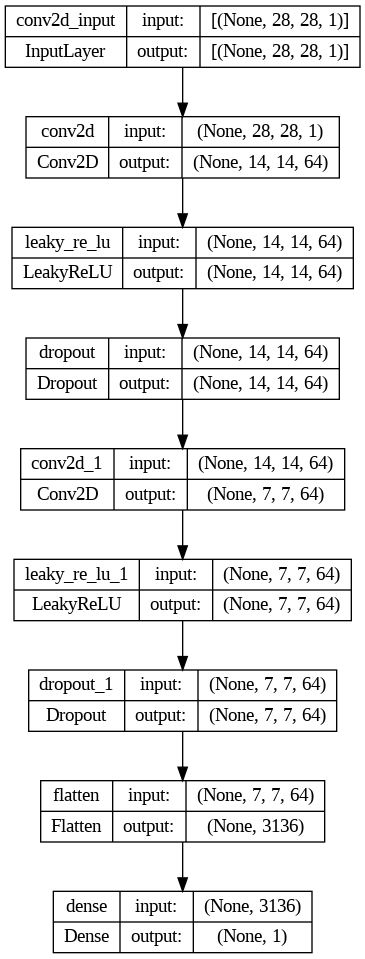

In [2]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential([
        Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape),
	    LeakyReLU(alpha=0.2),
	    Dropout(0.4),
	    Conv2D(64, (3,3), strides=(2, 2), padding='same'),
	    LeakyReLU(alpha=0.2),
	    Dropout(0.4),
	    Flatten(),
	    Dense(1, activation='sigmoid')
     ])

	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
	return model
model = define_discriminator()

model.summary()

plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [3]:
def load_real_samples():
    (tr_img, _), (te_img, _) = load_data()
    train_img = np.concatenate((tr_img, te_img))
    X = expand_dims(train_img, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X


In [4]:
def generate_real_samples(dataset, n_samples):

	rand_ind = np.random.randint(0, dataset.shape[0], n_samples)
	real_img = dataset[rand_ind]

	real_y = np.ones((n_samples, 1))
	return real_img,real_y

In [5]:
# def generate_fake_samples(n_samples):
# 	# generate uniform random numbers in [0,1]
# 	X = np.random.rand(28 * 28 * n_samples)
# 	# reshape into a batch of grayscale images
# 	X = X.reshape((n_samples, 28, 28, 1))
# 	# generate 'fake' class labels (0)
# 	y = np.zeros((n_samples, 1))
# 	return X, y

In [6]:
def train_discriminator(model, dataset, n_iter=100, batch_size=256):
	half_size = int(batch_size / 2)

	for i in range(n_iter):

		X_real, y_real = generate_real_samples(dataset, half_size)
		_, real_acc = model.train_on_batch(X_real, y_real)

		X_fake, y_fake = generate_fake_samples(half_size)
		_, fake_acc = model.train_on_batch(X_fake, y_fake)

		print(f'>{i+1}real={real_acc*100:.0f} fake={fake_acc*100:.0f}')

In [7]:

def define_generator(latent_dim=100):
	n_nodes = 128 * 7 * 7
	model = Sequential([

    Dense(n_nodes, input_dim=latent_dim),
	LeakyReLU(alpha=0.2),
	Reshape((7, 7, 128)),

	Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
	LeakyReLU(alpha=0.2),

	Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
    LeakyReLU(alpha=0.2),

	Conv2D(1, (7,7), activation='sigmoid', padding='same')
    ])
	return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                           

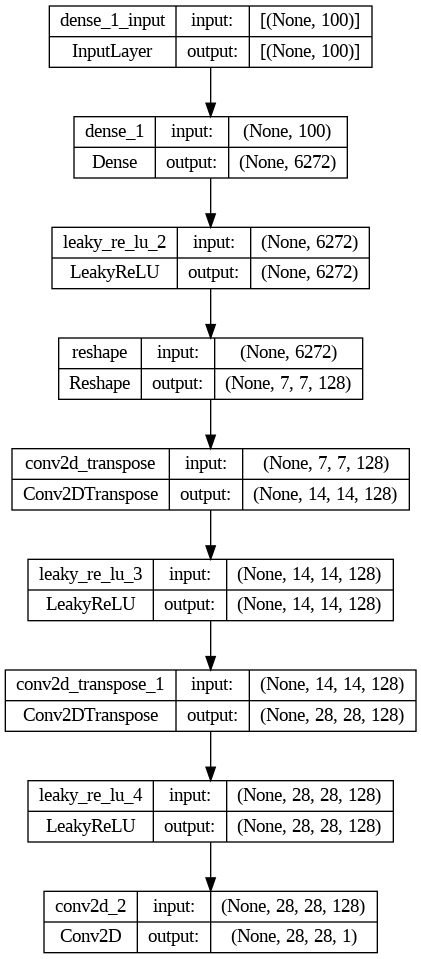

In [8]:
latent_dim = 100

model = define_generator(latent_dim)

model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [9]:

def generate_latent_points(latent_dim, n_samples):
	latent_points = np.random.randn(latent_dim * n_samples)
	latent_points =latent_points.reshape(n_samples, latent_dim)

	return latent_points

In [10]:

def generate_fake_samples(g_model, latent_dim, no_samples):

	latent_points = generate_latent_points(latent_dim, no_samples)
	fake_samp = g_model.predict(latent_points )

	lab_y = np.zeros((no_samples, 1))
	return fake_samp, lab_y

1/1 [==============================] - 3s 3s/step


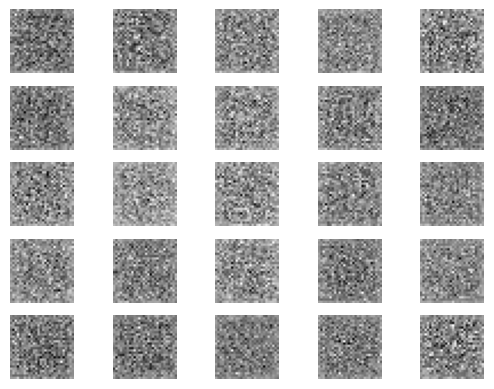

In [11]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
no_samples = 25
X, _ = generate_fake_samples(model, latent_dim, no_samples)
# plot the generated samples
for i in range(no_samples):
 # define subplot
 plt.subplot(5, 5, 1 + i)
 # turn off axis labels
 plt.axis('off')
 # plot single image
 plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

In [12]:

def define_gan(g_model, d_model):

	d_model.trainable = False

	model = Sequential([
    g_model,
	d_model
    ])

	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1204994 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 40705 (159.00 KB)
_________________________________________________________________


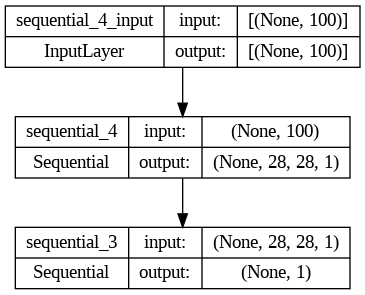

In [13]:

latent_dim = 100

dis_model = define_discriminator()
gen_model = define_generator(latent_dim)
gan_model = define_gan(gen_model, dis_model)

gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [14]:

from matplotlib import pyplot
def save_plot(examples, epoch, n=10):

	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')

	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [15]:

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):

	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

	print(f'>Accuracy real: {acc_real*100:.0f}, fake: {acc_fake*100:.0f}')

	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [16]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):

		for j in range(bat_per_epo):

			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

			d_loss, _ = d_model.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)

			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

			print(f'>{i+1}, {j+1}/{bat_per_epo}, d={d_loss:.3f}, g={ g_loss:.3f}')

		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [17]:
latent_dim=100
d_model=define_discriminator()
g_model=define_generator()
gan_model=define_gan(g_model,d_model)
dataset = load_real_samples()
train(dataset=dataset,g_model=g_model,d_model=d_model,gan_model=gan_model,n_epochs=100,latent_dim=latent_dim,n_batch=256)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
>1, 232/273, d=0.715, g=0.743
4/4 [==============================] - 0s 3ms/step
>1, 233/273, d=0.731, g=0.752
4/4 [==============================] - 0s 3ms/step
>1, 234/273, d=0.702, g=0.801
4/4 [==============================] - 0s 3ms/step
>1, 235/273, d=0.693, g=0.833
4/4 [==============================] - 0s 3ms/step
>1, 236/273, d=0.679, g=0.855
4/4 [==============================] - 0s 3ms/step
>1, 237/273, d=0.640, g=0.873
4/4 [==============================] - 0s 3ms/step
>1, 238/273, d=0.635, g=0.920
4/4 [==============================] - 0s 3ms/step
>1, 239/273, d=0.627, g=0.901
4/4 [==============================] - 0s 4ms/step
>1, 240/273, d=0.617, g=0.883
4/4 [==============================] - 0s 3ms/step
>1, 241/273, d=0.631, g=0.870
4/4 [==============================] - 0s 4ms/step
>1, 242/273, d=0.639, g=0.879
4/4 [==============================] - 0s 4ms/step
>1, 243

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
>11, 232/273, d=0.691, g=0.726
4/4 [==============================] - 0s 4ms/step
>11, 233/273, d=0.687, g=0.744
4/4 [==============================] - 0s 5ms/step
>11, 234/273, d=0.688, g=0.672
4/4 [==============================] - 0s 5ms/step
>11, 235/273, d=0.676, g=0.666
4/4 [==============================] - 0s 5ms/step
>11, 236/273, d=0.695, g=0.810
4/4 [==============================] - 0s 5ms/step
>11, 237/273, d=0.685, g=0.749
4/4 [==============================] - 0s 4ms/step
>11, 238/273, d=0.688, g=0.656
4/4 [==============================] - 0s 5ms/step
>11, 239/273, d=0.688, g=0.666
4/4 [==============================] - 0s 6ms/step
>11, 240/273, d=0.693, g=0.684
4/4 [==============================] - 0s 6ms/step
>11, 241/273, d=0.687, g=0.719
4/4 [==============================] - 0s 5ms/step
>11, 242/273, d=0.690, g=0.740
4/4 [==============================] - 0s 4ms/s

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
>21, 232/273, d=0.687, g=0.713
4/4 [==============================] - 0s 4ms/step
>21, 233/273, d=0.684, g=0.727
4/4 [==============================] - 0s 3ms/step
>21, 234/273, d=0.677, g=0.707
4/4 [==============================] - 0s 5ms/step
>21, 235/273, d=0.686, g=0.705
4/4 [==============================] - 0s 3ms/step
>21, 236/273, d=0.691, g=0.773
4/4 [==============================] - 0s 3ms/step
>21, 237/273, d=0.686, g=0.702
4/4 [==============================] - 0s 4ms/step
>21, 238/273, d=0.689, g=0.664
4/4 [==============================] - 0s 3ms/step
>21, 239/273, d=0.695, g=0.807
4/4 [==============================] - 0s 4ms/step
>21, 240/273, d=0.702, g=0.627
4/4 [==============================] - 0s 3ms/step
>21, 241/273, d=0.692, g=0.748
4/4 [==============================] - 0s 3ms/step
>21, 242/273, d=0.699, g=0.763
4/4 [==============================] - 0s 4ms/s

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
>31, 232/273, d=0.689, g=0.712
4/4 [==============================] - 0s 5ms/step
>31, 233/273, d=0.700, g=0.758
4/4 [==============================] - 0s 4ms/step
>31, 234/273, d=0.687, g=0.682
4/4 [==============================] - 0s 6ms/step
>31, 235/273, d=0.698, g=0.692
4/4 [==============================] - 0s 5ms/step
>31, 236/273, d=0.680, g=0.699
4/4 [==============================] - 0s 3ms/step
>31, 237/273, d=0.687, g=0.699
4/4 [==============================] - 0s 4ms/step
>31, 238/273, d=0.696, g=0.715
4/4 [==============================] - 0s 3ms/step
>31, 239/273, d=0.686, g=0.700
4/4 [==============================] - 0s 4ms/step
>31, 240/273, d=0.695, g=0.718
4/4 [==============================] - 0s 6ms/step
>31, 241/273, d=0.677, g=0.689
4/4 [==============================] - 0s 4ms/step
>31, 242/273, d=0.693, g=0.691
4/4 [==============================] - 0s 4ms/s

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
>41, 232/273, d=0.696, g=0.679
4/4 [==============================] - 0s 4ms/step
>41, 233/273, d=0.689, g=0.732
4/4 [==============================] - 0s 4ms/step
>41, 234/273, d=0.697, g=0.682
4/4 [==============================] - 0s 3ms/step
>41, 235/273, d=0.697, g=0.682
4/4 [==============================] - 0s 4ms/step
>41, 236/273, d=0.689, g=0.739
4/4 [==============================] - 0s 4ms/step
>41, 237/273, d=0.693, g=0.725
4/4 [==============================] - 0s 3ms/step
>41, 238/273, d=0.692, g=0.700
4/4 [==============================] - 0s 3ms/step
>41, 239/273, d=0.694, g=0.739
4/4 [==============================] - 0s 4ms/step
>41, 240/273, d=0.693, g=0.711
4/4 [==============================] - 0s 4ms/step
>41, 241/273, d=0.691, g=0.670
4/4 [==============================] - 0s 4ms/step
>41, 242/273, d=0.696, g=0.683
4/4 [==============================] - 0s 4ms/s

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
>51, 232/273, d=0.689, g=0.714
4/4 [==============================] - 0s 4ms/step
>51, 233/273, d=0.690, g=0.729
4/4 [==============================] - 0s 4ms/step
>51, 234/273, d=0.698, g=0.685
4/4 [==============================] - 0s 3ms/step
>51, 235/273, d=0.689, g=0.705
4/4 [==============================] - 0s 4ms/step
>51, 236/273, d=0.694, g=0.736
4/4 [==============================] - 0s 4ms/step
>51, 237/273, d=0.693, g=0.692
4/4 [==============================] - 0s 4ms/step
>51, 238/273, d=0.692, g=0.667
4/4 [==============================] - 0s 4ms/step
>51, 239/273, d=0.691, g=0.724
4/4 [==============================] - 0s 4ms/step
>51, 240/273, d=0.691, g=0.702
4/4 [==============================] - 0s 3ms/step
>51, 241/273, d=0.697, g=0.682
4/4 [==============================] - 0s 3ms/step
>51, 242/273, d=0.691, g=0.728
4/4 [==============================] - 0s 4ms/s

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
>61, 232/273, d=0.687, g=0.678
4/4 [==============================] - 0s 4ms/step
>61, 233/273, d=0.694, g=0.697
4/4 [==============================] - 0s 4ms/step
>61, 234/273, d=0.695, g=0.712
4/4 [==============================] - 0s 4ms/step
>61, 235/273, d=0.689, g=0.702
4/4 [==============================] - 0s 4ms/step
>61, 236/273, d=0.692, g=0.710
4/4 [==============================] - 0s 4ms/step
>61, 237/273, d=0.700, g=0.704
4/4 [==============================] - 0s 6ms/step
>61, 238/273, d=0.689, g=0.691
4/4 [==============================] - 0s 4ms/step
>61, 239/273, d=0.691, g=0.683
4/4 [==============================] - 0s 4ms/step
>61, 240/273, d=0.694, g=0.698
4/4 [==============================] - 0s 6ms/step
>61, 241/273, d=0.689, g=0.704
4/4 [==============================] - 0s 5ms/step
>61, 242/273, d=0.696, g=0.705
4/4 [==============================] - 0s 5ms/s

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
>71, 232/273, d=0.707, g=0.724
4/4 [==============================] - 0s 4ms/step
>71, 233/273, d=0.699, g=0.687
4/4 [==============================] - 0s 3ms/step
>71, 234/273, d=0.688, g=0.674
4/4 [==============================] - 0s 5ms/step
>71, 235/273, d=0.687, g=0.725
4/4 [==============================] - 0s 4ms/step
>71, 236/273, d=0.693, g=0.698
4/4 [==============================] - 0s 3ms/step
>71, 237/273, d=0.694, g=0.671
4/4 [==============================] - 0s 4ms/step
>71, 238/273, d=0.693, g=0.710
4/4 [==============================] - 0s 3ms/step
>71, 239/273, d=0.688, g=0.725
4/4 [==============================] - 0s 4ms/step
>71, 240/273, d=0.694, g=0.712
4/4 [==============================] - 0s 3ms/step
>71, 241/273, d=0.704, g=0.712
4/4 [==============================] - 0s 4ms/step
>71, 242/273, d=0.694, g=0.719
4/4 [==============================] - 0s 3ms/s

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
>81, 232/273, d=0.691, g=0.683
4/4 [==============================] - 0s 4ms/step
>81, 233/273, d=0.696, g=0.708
4/4 [==============================] - 0s 4ms/step
>81, 234/273, d=0.700, g=0.732
4/4 [==============================] - 0s 4ms/step
>81, 235/273, d=0.698, g=0.688
4/4 [==============================] - 0s 4ms/step
>81, 236/273, d=0.705, g=0.662
4/4 [==============================] - 0s 4ms/step
>81, 237/273, d=0.696, g=0.726
4/4 [==============================] - 0s 4ms/step
>81, 238/273, d=0.695, g=0.724
4/4 [==============================] - 0s 3ms/step
>81, 239/273, d=0.696, g=0.681
4/4 [==============================] - 0s 5ms/step
>81, 240/273, d=0.698, g=0.687
4/4 [==============================] - 0s 4ms/step
>81, 241/273, d=0.694, g=0.713
4/4 [==============================] - 0s 5ms/step
>81, 242/273, d=0.694, g=0.674
4/4 [==============================] - 0s 4ms/s

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
>91, 232/273, d=0.693, g=0.686
4/4 [==============================] - 0s 4ms/step
>91, 233/273, d=0.692, g=0.703
4/4 [==============================] - 0s 4ms/step
>91, 234/273, d=0.690, g=0.700
4/4 [==============================] - 0s 4ms/step
>91, 235/273, d=0.706, g=0.711
4/4 [==============================] - 0s 4ms/step
>91, 236/273, d=0.694, g=0.680
4/4 [==============================] - 0s 4ms/step
>91, 237/273, d=0.688, g=0.672
4/4 [==============================] - 0s 5ms/step
>91, 238/273, d=0.689, g=0.719
4/4 [==============================] - 0s 4ms/step
>91, 239/273, d=0.684, g=0.710
4/4 [==============================] - 0s 4ms/step
>91, 240/273, d=0.694, g=0.700
4/4 [==============================] - 0s 4ms/step
>91, 241/273, d=0.688, g=0.703
4/4 [==============================] - 0s 4ms/step
>91, 242/273, d=0.698, g=0.725
4/4 [==============================] - 0s 4ms/s

1/1 [==============================] - 0s 157ms/step


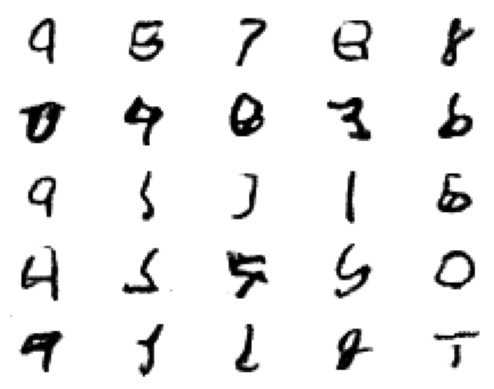

In [26]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)